## Libraries

In [ ]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')
%config Completer.use_jedi = False

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

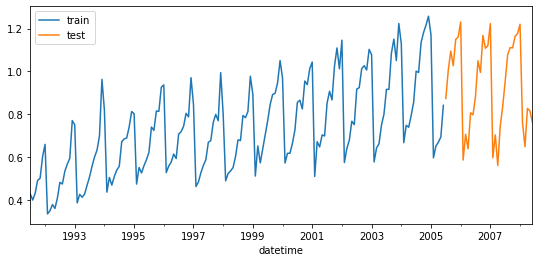

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Train forecaster

In [3]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 10):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train  

In [4]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: create_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2021-12-06 23:30:30 
Last fit date: 2021-12-06 23:30:31 
Skforecast version: 0.4.dev 

## Prediction

In [5]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(3)

2005-07-01    0.926598
2005-08-01    0.948202
2005-09-01    1.020947
Freq: MS, Name: pred, dtype: float64

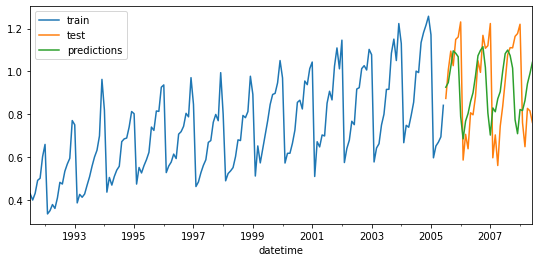

In [6]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [7]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.04487765885818191


## Feature importance

In [9]:
forecaster.get_feature_importance()

,feature,importance
0,custom_predictor_0,0.539720
1,custom_predictor_1,0.119097
2,custom_predictor_2,0.046404
3,custom_predictor_3,0.024165
4,custom_predictor_4,0.030567
5,custom_predictor_5,0.015139
6,custom_predictor_6,0.042883
7,custom_predictor_7,0.012742
8,custom_predictor_8,0.018938
9,custom_predictor_9,0.108639


In [10]:
print(forecaster.get_feature_importance().to_markdown(index=False))

| feature             |   importance |
|:--------------------|-------------:|
| custom_predictor_0  |    0.53972   |
| custom_predictor_1  |    0.119097  |
| custom_predictor_2  |    0.0464036 |
| custom_predictor_3  |    0.0241653 |
| custom_predictor_4  |    0.0305667 |
| custom_predictor_5  |    0.0151391 |
| custom_predictor_6  |    0.0428832 |
| custom_predictor_7  |    0.012742  |
| custom_predictor_8  |    0.018938  |
| custom_predictor_9  |    0.108639  |
| custom_predictor_10 |    0.0417066 |


## Extract training matrix

In [11]:
X, y = forecaster.create_train_X_y(data_train)
print(X.head().to_markdown())

| datetime            |   custom_predictor_0 |   custom_predictor_1 |   custom_predictor_2 |   custom_predictor_3 |   custom_predictor_4 |   custom_predictor_5 |   custom_predictor_6 |   custom_predictor_7 |   custom_predictor_8 |   custom_predictor_9 |   custom_predictor_10 |
|:--------------------|---------------------:|---------------------:|---------------------:|---------------------:|---------------------:|---------------------:|---------------------:|---------------------:|---------------------:|---------------------:|----------------------:|
| 1993-03-01 00:00:00 |             0.387554 |             0.751503 |             0.771258 |             0.595223 |             0.568606 |             0.534761 |             0.475463 |             0.483389 |             0.410534 |             0.361801 |              0.496401 |
| 1993-04-01 00:00:00 |             0.427283 |             0.387554 |             0.751503 |             0.771258 |             0.595223 |             0.568606 |     

In [12]:
print(y.head().to_markdown())

| datetime            |        y |
|:--------------------|---------:|
| 1993-03-01 00:00:00 | 0.427283 |
| 1993-04-01 00:00:00 | 0.41389  |
| 1993-05-01 00:00:00 | 0.428859 |
| 1993-06-01 00:00:00 | 0.470126 |
| 1993-07-01 00:00:00 | 0.50921  |
